## Loading data and image segmentation

In this lab, we'll work with hyperspectral imaging data. We'll start by loading the data and visualizing it in both grayscale and an RGB-like format to get an initial sense of what we're working with.

Next, we'll use the Segment Anything framework to segment the image and generate masks. We'll then filter these masks by size and remove any overlapping regions to clean up our segmentation results.

After that, we'll extract and plot the spectral signatures of each remaining mask. From these, we'll identify the masks that correspond to kiwi spectra and keep only those. Finally, we'll sort the selected masks and save their spectral data, which will be used as input for future labs.

Let's start by loading a .mat file using scipy.io.loadmat function and inspecting the object.

In [21]:
import scipy.io
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

filepath = "data/1A.mat"
mat = scipy.io.loadmat(filepath)
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Wavelength', 'img'])

The fields such as `__header__`, `__version__`, `__globals__` are automatically generated by Matlab. Let's inspect the contents of fields `Wavelength` and `img`

In [22]:
mat["Wavelength"]

array([[ 398.86],
       [ 401.4 ],
       [ 403.95],
       [ 406.5 ],
       [ 409.05],
       [ 411.61],
       [ 414.16],
       [ 416.73],
       [ 419.29],
       [ 421.86],
       [ 424.43],
       [ 427.  ],
       [ 429.57],
       [ 432.15],
       [ 434.73],
       [ 437.31],
       [ 439.9 ],
       [ 442.49],
       [ 445.08],
       [ 447.67],
       [ 450.27],
       [ 452.86],
       [ 455.46],
       [ 458.07],
       [ 460.67],
       [ 463.28],
       [ 465.89],
       [ 468.5 ],
       [ 471.12],
       [ 473.73],
       [ 476.35],
       [ 478.97],
       [ 481.59],
       [ 484.22],
       [ 486.84],
       [ 489.47],
       [ 492.1 ],
       [ 494.74],
       [ 497.37],
       [ 500.01],
       [ 502.65],
       [ 505.29],
       [ 507.93],
       [ 510.58],
       [ 513.22],
       [ 515.87],
       [ 518.52],
       [ 521.17],
       [ 523.82],
       [ 526.48],
       [ 529.13],
       [ 531.79],
       [ 534.45],
       [ 537.11],
       [ 539.78],
       [ 5

In [23]:
mat["Wavelength"].shape

(224, 1)

As we can see the field `Wavelength` contains an array with values of wavelenths at which the hyperspectral image was obtained. There are 224 unique wavelengths, ranging from 398.86 till 1002.2

Next let's inspect the`img` part:

In [24]:
mat["img"].shape

(930, 1024, 224)

Our image is 930 pixels by 1024. Each pixel has it's intensity values recorded at 224 distinct wavelengths. Let's visualize how it looks like at one of the wavelengths

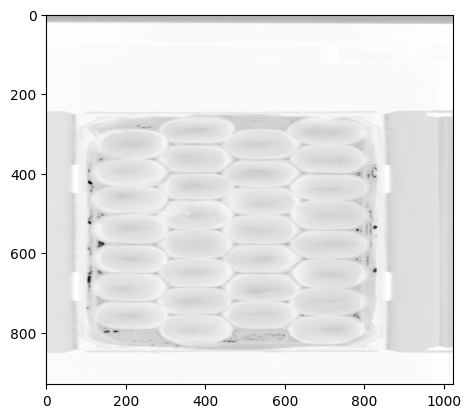

In [25]:
fig = plt.figure()
plt.imshow(mat["img"][:,:,150], cmap='Greys')

Let's construct a pseudo-RGB image out of this hyperspectral image. In order to do so we need to combine 3 images at wavelengths roughly corresponding to red (around 600 nm), green (around 550 nm), and blue (around 450 nm).  
or 445, 535, 575?

In [26]:
print(mat["Wavelength"][18], mat["Wavelength"][52], mat["Wavelength"][67])

[445.08] [534.45] [574.53]


In [27]:
red = 575
green = 535
blue = 445

def find_closest_index(target, array):
    array = np.asarray(array)
    idx = np.abs(array - target).argmin()
    return idx

def create_pseudo_rgb_image(hyperspectral_image, wavelengths):
    r_index = find_closest_index(red,wavelengths)
    g_index = find_closest_index(green,wavelengths)
    b_index = find_closest_index(blue,wavelengths)
    rgb_img = np.stack([
        hyperspectral_image[:, :, r_index],
        hyperspectral_image[:, :, g_index],
        hyperspectral_image[:, :, b_index]
    ], axis=-1)


    # TODO explain why we need to normalize, why can there be negative values?
    # Initialize normalized image
    norm_img = np.empty_like(rgb_img, dtype=np.float32)

    # Normalize each channel independently
    for i in range(3):
        channel = rgb_img[:, :, i]
        vmin = np.percentile(channel, 1)
        vmax = np.percentile(channel, 99)
        norm_img[:, :, i] = np.clip((channel - vmin) / (vmax - vmin), 0, 1)

    # Convert to uint8
    rgb_uint8 = (norm_img * 255).astype(np.uint8)
    return rgb_uint8

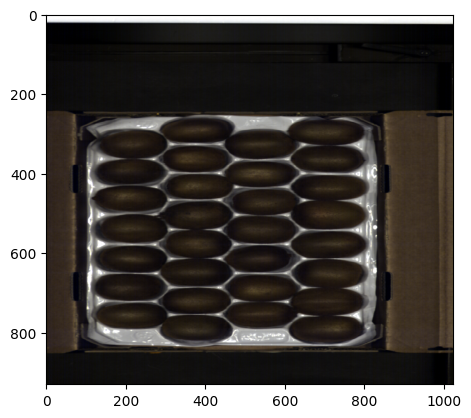

In [28]:
rgb_img = create_pseudo_rgb_image(mat["img"], mat["Wavelength"])
fig = plt.figure()
plt.imshow(rgb_img)

# Segmentation and object detection

## Deep learning segmentation

In order to analyze just the spectra related to kiwi fruits we need to segment the image first. There are various ways to do it, but the easiest and perhaps most accessible is to use deep learning models. In the next section we will segment the image using Segment Anything framework. The code below works fastest if you have a GPU.

In [29]:
# Let's check if your machine has an access to GPU
!nvidia-smi

Wed May 28 17:32:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.106                Driver Version: 552.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5500 Laptop GPU    On  |   00000000:01:00.0  On |                  Off |
| N/A   45C    P5             19W /  115W |    7744MiB /  16384MiB |     25%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [30]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import supervision as sv

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE = {DEVICE}")

MODEL_TYPE = "vit_h"
SAM_SAM_CHECKPOINT_PATH = "weights/sam_vit_h_4b8939.pth"

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_SAM_CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam, )
sam_result = mask_generator.generate(rgb_img)
sam_detections = sv.Detections.from_sam(sam_result=sam_result)

DEVICE = cuda:0


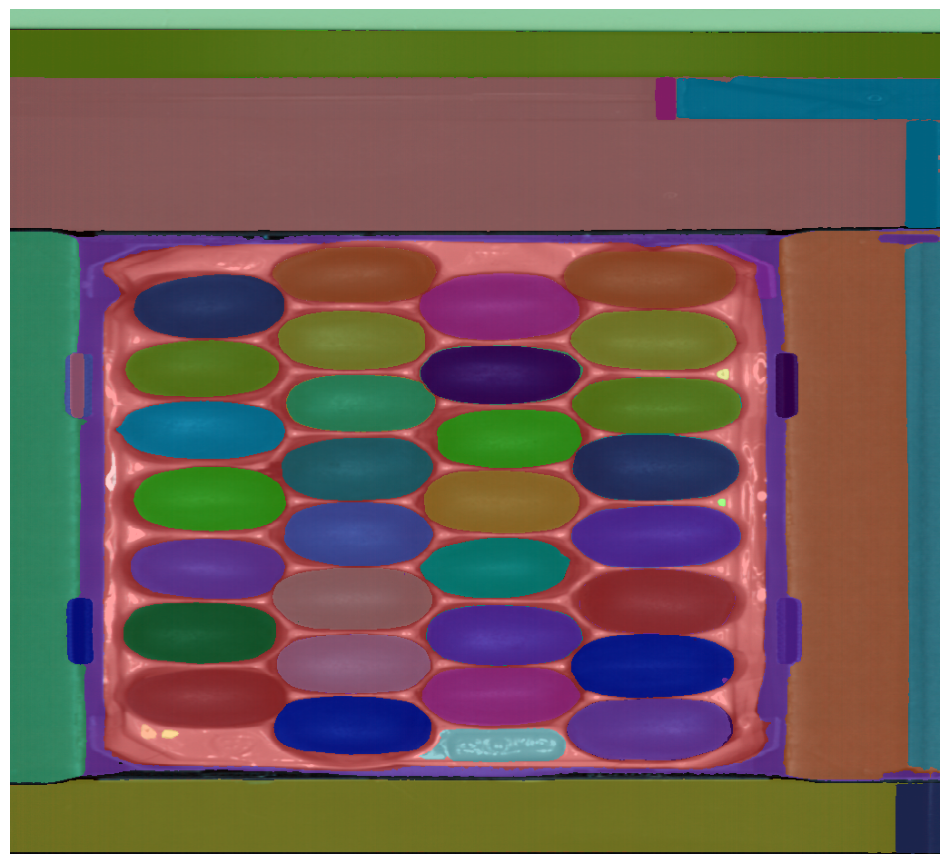

In [31]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
sam_result = mask_annotator.annotate(scene=rgb_img.copy(), detections=sam_detections)
sv.plot_image(image=sam_result)

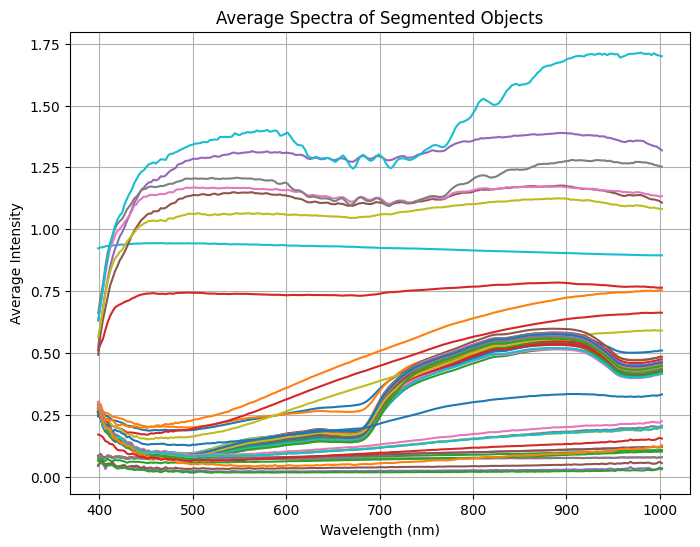

In [32]:
# Extract data
hyperspectral_img = mat["img"]
wavelengths = mat["Wavelength"]

# Plot the spectra for each mask
plt.figure(figsize=(8, 6))

for i, mask in enumerate(sam_detections.mask):
    masked_pixels = hyperspectral_img[mask]
    avg_spectrum = masked_pixels.mean(axis=0)

    # Plot the average spectrum for this object
    plt.plot(wavelengths, avg_spectrum)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Average Intensity")
plt.title("Average Spectra of Segmented Objects")
plt.grid(True)
plt.show()

In [33]:
filtered_masks = []
filtered_indices = []

for i, mask in enumerate(sam_detections.mask):
    if mask.shape != hyperspectral_img.shape[:2]:
        continue

    # Get non-zero pixel coordinates
    y_coords, x_coords = np.where(mask)

    if y_coords.size == 0 or x_coords.size == 0:
        continue  # skip empty masks

    height = y_coords.max() - y_coords.min() + 1
    width = x_coords.max() - x_coords.min() + 1

    if 40 <= height <= 100 and 150 <= width <= 200:
        filtered_masks.append(mask)
        filtered_indices.append(i)

In [34]:
# Get corresponding fields from the original detections
filtered_xyxy = []
filtered_masks = []

# Only include valid masks (non-None)
for i in filtered_indices:
    mask = sam_detections.mask[i]
    if mask is not None and mask.shape == hyperspectral_img.shape[:2]:
        filtered_xyxy.append(sam_detections.xyxy[i])
        filtered_masks.append(mask)

# Ensure we have valid data
if len(filtered_masks) > 0:
    filtered_detections = sv.Detections(
        xyxy=np.array(filtered_xyxy),
        mask=np.array(filtered_masks)
    )
else:
    print("No valid masks to plot!")

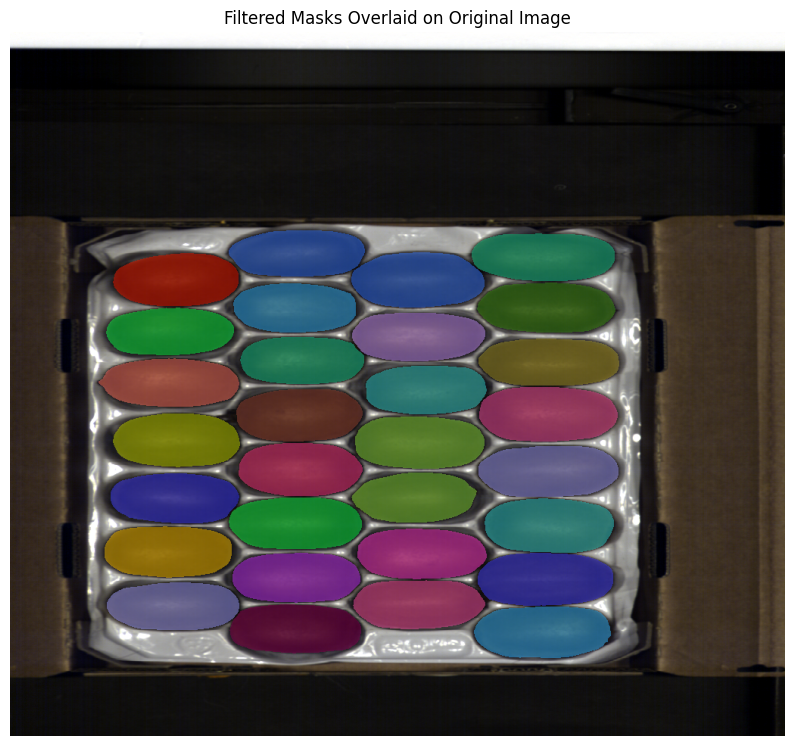

In [35]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

# Create the annotated image
annotated_img = mask_annotator.annotate(scene=rgb_img.copy(), detections=filtered_detections)

# Plot the original image with overlaid masks
plt.figure(figsize=(10, 10))
plt.imshow(annotated_img)
plt.axis("off")
plt.title("Filtered Masks Overlaid on Original Image")
plt.show()

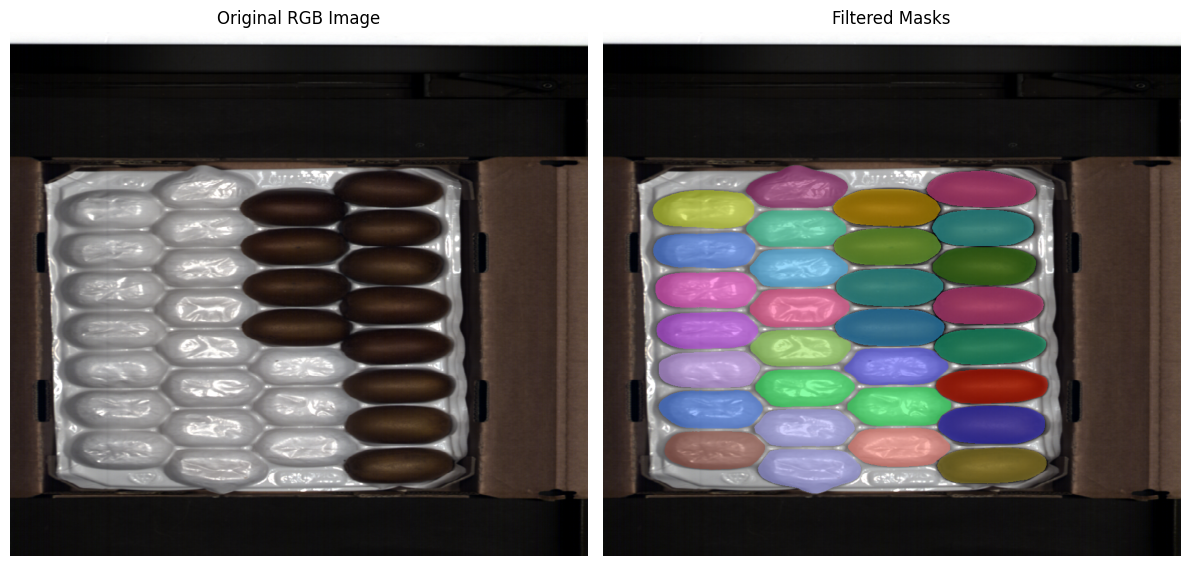

In [36]:
# Specify path to the .mat file
filepath = "data/gold_5A.mat"  # <-- Replace with the specific image filename

# Load the .mat file
mat = scipy.io.loadmat(filepath)
img = mat["img"]

# Construct RGB image
rgb_img = [img[:, :, 70], img[:, :, 50], img[:, :, 30]]
rgb_img = np.stack(rgb_img, axis=-1)

# Normalize and convert to uint8
vmin = np.percentile(rgb_img, 1)
vmax = np.percentile(rgb_img, 99)
rgb_img = np.clip(rgb_img, vmin, vmax)
rgb_img = (255 * (rgb_img - vmin) / (vmax - vmin)).astype(np.uint8)

# Segment Anything setup
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
SAM_SAM_CHECKPOINT_PATH = "weights/sam_vit_h_4b8939.pth"
sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_SAM_CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

# Generate masks
sam_result = mask_generator.generate(rgb_img)
sam_detections = sv.Detections.from_sam(sam_result=sam_result)

# Filter masks by bounding box size
filtered_masks = []
filtered_xyxy = []
for i, mask in enumerate(sam_detections.mask):
    if mask.shape != rgb_img.shape[:2]:
        continue

    y_coords, x_coords = np.where(mask)
    if y_coords.size == 0 or x_coords.size == 0:
        continue

    height = y_coords.max() - y_coords.min() + 1
    width = x_coords.max() - x_coords.min() + 1

    if 40 <= height <= 100 and 150 <= width <= 200:
        filtered_masks.append(mask)
        filtered_xyxy.append(sam_detections.xyxy[i])

def remove_overlapping_masks(masks, xyxy):
    occupied = np.zeros_like(masks[0], dtype=bool)
    non_overlapping_masks = []
    non_overlapping_xyxy = []

    for mask, box in zip(masks, xyxy):
        if not np.any(mask & occupied):
            non_overlapping_masks.append(mask)
            non_overlapping_xyxy.append(box)
            occupied |= mask  # mark area as taken

    return non_overlapping_masks, non_overlapping_xyxy

filtered_masks, filtered_xyxy = remove_overlapping_masks(filtered_masks, filtered_xyxy)

# If valid masks exist, create a Detections object and annotate
if filtered_masks:
    filtered_detections = sv.Detections(
        xyxy=np.array(filtered_xyxy),
        mask=np.array(filtered_masks)
    )
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    annotated_img = mask_annotator.annotate(scene=rgb_img.copy(), detections=filtered_detections)

    # Plot side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(rgb_img)
    axs[0].set_title("Original RGB Image")
    axs[0].axis("off")

    axs[1].imshow(annotated_img)
    axs[1].set_title("Filtered Masks")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

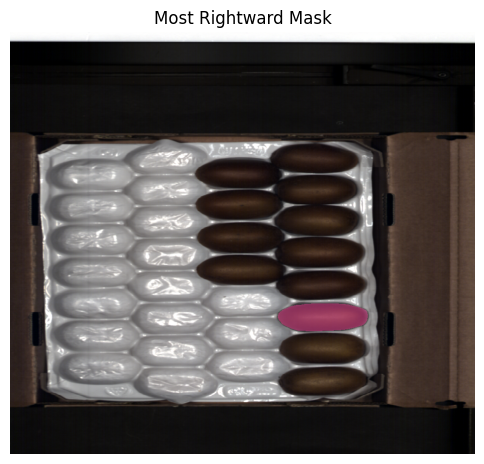

In [37]:
# Ensure bounding boxes are numpy arrays
filtered_xyxy = [np.array(box) for box in filtered_xyxy]

# Find the index with the highest x2 (right edge)
x2_values = [box[2] for box in filtered_xyxy]
rightmost_index = int(np.argmax(x2_values))

rightmost_mask = filtered_masks[rightmost_index]
rightmost_box = filtered_xyxy[rightmost_index]

rightmost_detection = sv.Detections(
    xyxy=np.array([rightmost_box]),
    mask=np.array([rightmost_mask])
)

rightmost_annotated = mask_annotator.annotate(scene=rgb_img.copy(), detections=rightmost_detection)

plt.figure(figsize=(6, 6))
plt.imshow(rightmost_annotated)
plt.title("Most Rightward Mask")
plt.axis("off")
plt.show()

In [38]:
kiwi_pixels = hyperspectral_img[rightmost_mask]
kiwi_avg_spectrum = masked_pixels.mean(axis=0)

0.062413582496781264
0.011112296618647209
0.38303453719822045
0.3965725941861181
0.03095958092117599
0.07067771637027644
0.39103202102257917
0.05428192889281976
0.042069351424048544
0.045957872551565956
0.4098076419726862
0.016887081446567538
0.08074548960394982
0.40371319657546023
0.3908171490581522
0.0
0.3808873752720697
0.3876116792264121
0.39739886745875763
0.4033621959154171
0.39448524881079233
0.0664646775129459
0.3994438166258967
0.39142724272902857
0.4040782449925172
0.3866068733349431
0.06291154742823221
0.3889538633217287
0.3948471303662595
0.3915285258856574


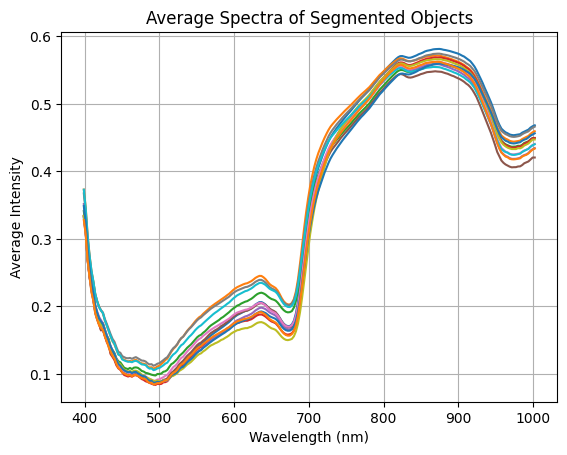

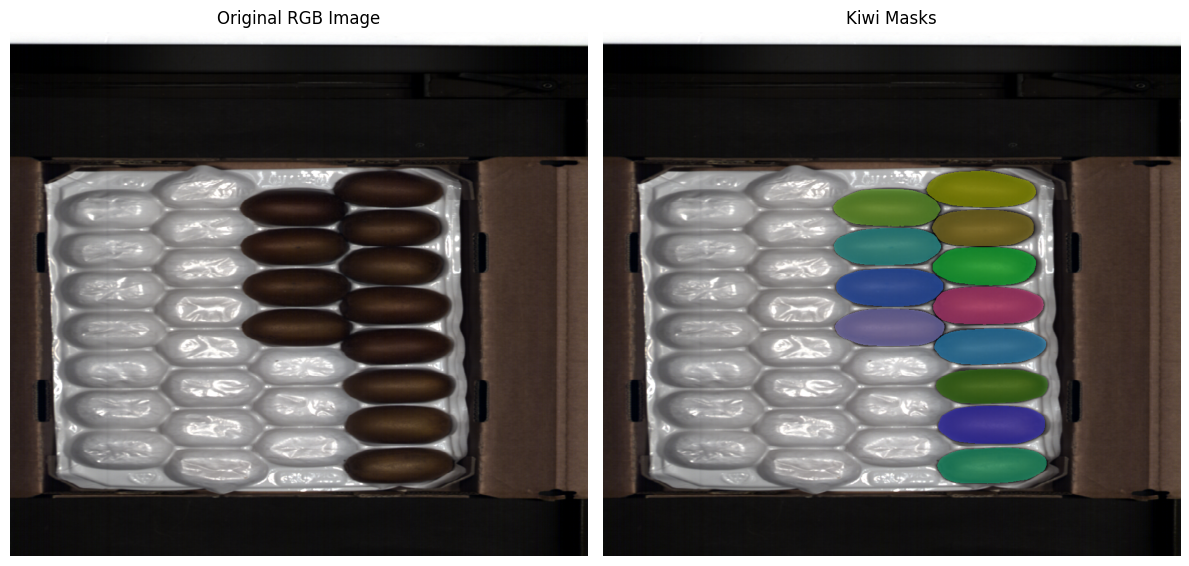

In [39]:
from pysptools.distance import SAM

kiwi_masks = []
kiwi_xyxy = []

hyperspectral_img = mat["img"]            # Shape: (H, W, Bands)
wavelengths = mat["Wavelength"]

# Get index of rightmost mask in sam_detections.mask
rightmost_index_global = None
for i, mask in enumerate(filtered_masks):
    if np.array_equal(mask, rightmost_mask):
        rightmost_index_global = i
        break

kiwi_pixels = hyperspectral_img[filtered_masks[rightmost_index_global]]
kiwi_avg_spectrum = kiwi_pixels.mean(axis=0)

for i, mask in enumerate(filtered_masks):
    masked_pixels = hyperspectral_img[mask]
    avg_spectrum = masked_pixels.mean(axis=0)
    sam_score = SAM(kiwi_avg_spectrum, avg_spectrum)
    print(sam_score)
    if sam_score < 0.1:
        kiwi_masks.append(mask)
        kiwi_xyxy.append(filtered_xyxy[i])
            # Plot the average spectrum for this object
    
        plt.plot(wavelengths, avg_spectrum, label=f"Object {i}")

# Add labels, title, and legend
plt.xlabel("Wavelength (nm)")
plt.ylabel("Average Intensity")
plt.title("Average Spectra of Segmented Objects")
plt.grid(True)

# Show the plot
plt.show()


if kiwi_masks:
    kiwi_detections = sv.Detections(
        xyxy=np.array(kiwi_xyxy),
        mask=np.array(kiwi_masks)
    )
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    annotated_img = mask_annotator.annotate(scene=rgb_img.copy(), detections=kiwi_detections)

    # Plot side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(rgb_img)
    axs[0].set_title("Original RGB Image")
    axs[0].axis("off")

    axs[1].imshow(annotated_img)
    axs[1].set_title("Kiwi Masks")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

In [40]:
def compute_centroid(mask):
    y_coords, x_coords = np.where(mask)
    if len(x_coords) == 0 or len(y_coords) == 0:
        return None  # empty mask
    cx = np.mean(x_coords)
    cy = np.mean(y_coords)
    return (cx, cy)

In [41]:
# Step 1: Compute centroids
centroids = []
for mask in kiwi_detections.mask:
    y_coords, x_coords = np.where(mask)
    if len(x_coords) == 0 or len(y_coords) == 0:
        centroids.append((0, 0))  # fallback
    else:
        cx = np.mean(x_coords)
        cy = np.mean(y_coords)
        centroids.append((cx, cy))

# Step 2: Sort indices
sorted_indices = sorted(
    range(len(centroids)),
    key=lambda i: (-centroids[i][0], centroids[i][1])  # right to left, top to bottom
)

# Step 3: Reorder masks and bounding boxes
sorted_masks = [kiwi_masks[i] for i in sorted_indices]
sorted_xyxy = [kiwi_xyxy[i] for i in sorted_indices]

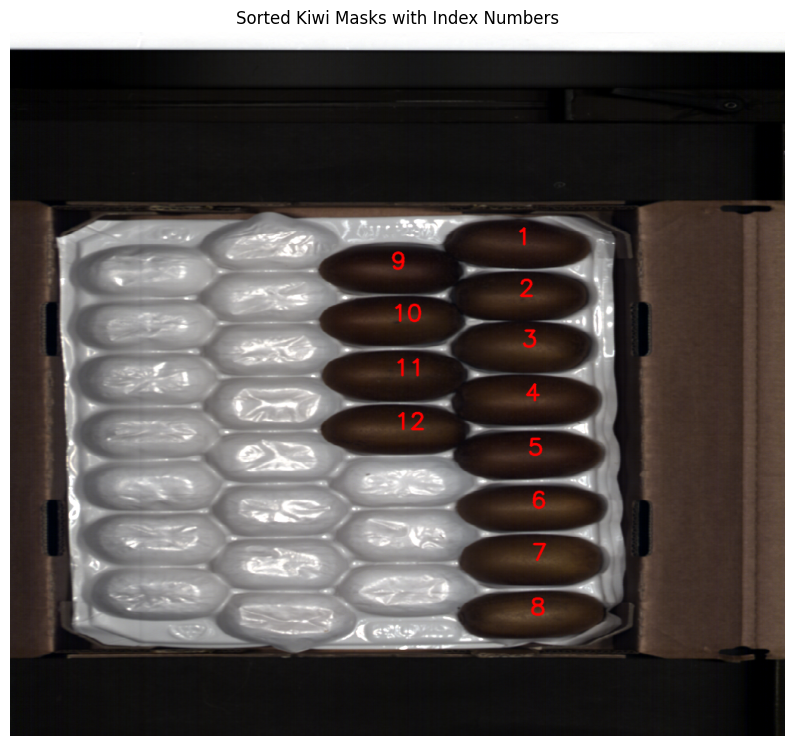

In [42]:
# Make a copy of the image for annotation
labeled_img = rgb_img.copy()

from sklearn.cluster import DBSCAN

# Compute centroids
centroids = []
for mask in kiwi_masks:
    y_coords, x_coords = np.where(mask)
    cx = int(np.mean(x_coords))
    cy = int(np.mean(y_coords))
    centroids.append((cx, cy))

centroids = np.array(centroids)

# Cluster by x-coordinate only (to group into columns)
clustering = DBSCAN(eps=50, min_samples=1).fit(centroids[:, [0]])  # adjust eps depending on spacing
labels = clustering.labels_

# Group centroids and masks by cluster
clustered = {}
for label, centroid, mask in zip(labels, centroids, kiwi_masks):
    clustered.setdefault(label, []).append((centroid, mask))

# Sort columns from right to left
sorted_columns = sorted(clustered.items(), key=lambda item: -np.mean([c[0][0] for c in item[1]]))

# For each column, sort top to bottom
sorted_masks = []
for _, column in sorted_columns:
    sorted_column = sorted(column, key=lambda x: x[0][1])  # sort by y (top to bottom)
    sorted_masks.extend([m for _, m in sorted_column])



# Make a copy of the image to draw on
labeled_img = rgb_img.copy()

# Loop through sorted masks and draw the index number
for idx, mask in enumerate(sorted_masks):
    y_coords, x_coords = np.where(mask)
    if y_coords.size == 0 or x_coords.size == 0:
        continue

    # Compute centroid
    cx = int(np.mean(x_coords))
    cy = int(np.mean(y_coords))

    # Draw the index number using OpenCV
    cv2.putText(
        labeled_img, str(idx + 1), (cx, cy),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=1,
        color=(255, 0, 0),  # Blue text
        thickness=2,
        lineType=cv2.LINE_AA
    )

# Show the result
plt.figure(figsize=(10, 10))
plt.imshow(labeled_img)
plt.title("Sorted Kiwi Masks with Index Numbers")
plt.axis("off")
plt.show()